# 1. Install and import libraries and modules

In [84]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [86]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os
import shutil
import geopandas as gpd
import catboost as cb
import optuna
import lightgbm as lgb
import h2o

from h2o.estimators import H2OGradientBoostingEstimator
from xgboost import XGBRegressor, plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import squared_log, add_city_centre_dist, group_ages, to_categorical, nan_to_string, object_encoder, only_2016_data, add_spatial_clusters
from objectives_and_metrics import rmsle, RmsleMetric, RmsleObjective, LogTargetsRmsleMetric, RmseObjective
from scipy.stats import uniform, randint
from typing import Callable, Dict
from catboost.utils import get_gpu_device_count

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

SEED = 23

spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv') 

submission = pd.read_csv('data/sample_submission.csv')

# 2. EDA

## 2.x Data cleaning

The train and test data only contains data from 2016, so for the other datasets with an age column
we only use the values from 2016, where possible. 

In [87]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

spatial_2016 = only_2016_data(spatial)
income_2016 = only_2016_data(income)
households_2016 = only_2016_data(households)

train_spatial = train.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
muni_avg_revenue = train_spatial.groupby(by='municipality_name', as_index=False)['revenue'].mean()

Futhermore, we noticed that a number of rows in the train and test datasets didn't have  

In [88]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    # plt.hist(np.log1p(train.revenue), 30)
    # plt.show()
    return df.drop(columns=['revenue']), df.revenue


def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    # df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')  # kanskje var med i prediksjonen...
    df2 = df.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_2016.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df[
        ~(df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())  # | df2.age_0_19.isna() 
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned


train_test_clustered = add_spatial_clusters(pd.concat([train.drop(columns=['revenue']), test], axis=0).reset_index())
train_test_clustered = train_test_clustered[['store_id', 'cluster_id', 'cluster_member_count', 'closest_cluster_centroid_dist']]

train = train.merge(train_test_clustered, on='store_id', how='left')
test = test.merge(train_test_clustered, on='store_id', how='left')

print(len(train), len(test))

train = clean_out_nan_heavy_rows(train)
label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8, random_state=SEED)
X_train, y_train = clean(pd.merge(X_train, y_train, left_index=True, right_index=True))

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

X_train.isna().sum()

26 clusters created
Cluster counts: {-1: 5882, 0: 7293, 1: 155, 2: 219, 3: 823, 4: 1156, 5: 104, 6: 1413, 7: 181, 8: 143, 9: 139, 10: 414, 11: 310, 12: 385, 13: 520, 14: 515, 15: 211, 16: 180, 17: 414, 18: 315, 19: 113, 20: 113, 21: 105, 22: 126, 23: 103, 24: 104}
Calculating distance to closest cluster for each data point...


100%|██████████| 21436/21436 [00:59<00:00, 361.34it/s]


12859 8577
Cleaned out 127 out of 12859 rows.
Length of data frame: 10185
Length after removing extreme values and zero revenue retail stores: 9947


store_id                            0
year                                0
store_name                          0
plaace_hierarchy_id                 0
sales_channel_name                  0
grunnkrets_id                       0
address                          1369
lat                                 0
lon                                 0
chain_name                       7055
mall_name                        8195
cluster_id                          0
cluster_member_count                0
closest_cluster_centroid_dist       0
dtype: int64

# 3. Feature generation

In [89]:
def generate_features(df: pd.DataFrame, data_origin: str, predictor: str = ''):
    # Define datasets to be merged
    age_groups_merge = group_ages(age, age_ranges)
    spatial_merge = spatial_2016.drop(columns=['year'])
    income_merge = income_2016.drop(columns=['year'])
    households_merge = households_2016.drop(columns=['year'])
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet(f'derived_data/stores_bus_stops_lt_1km_{data_origin}').drop(columns=['geometry'])
    stores_vicinity_merge = gpd.read_parquet(f'derived_data/stores_count_lt_1km_{data_origin}').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    # df = df.merge(muni_avg_revenue, on='municipality_name', how='left', suffixes=(None, '_muni_avg'))
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = df.merge(stores_vicinity_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # Transformations and some post-merge cleaning
    df.stores_count_lt_1km = np.log(df.stores_count_lt_1km)
    df.closest_cluster_centroid_dist = np.log(df.closest_cluster_centroid_dist)
    df[age_groups_merge.columns] = df[age_groups_merge.columns].fillna(0)
    

    # Handle categories for different predictors
    if predictor == 'xgb':
        # df = to_categorical(df)
        df = object_encoder(df)
    elif predictor == 'cb':
        df = nan_to_string(df)
    elif predictor == 'lgb' or predictor == 'h2o':
        df = to_categorical(df)
    elif predictor == 'rf':
        df = object_encoder(df)
    else: 
        raise ValueError('Invalid predictor')

    features = [
        'store_name', 
        'mall_name', 
        'chain_name',
        'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc', 'sales_channel_name',  # 'lv3_desc', 'lv4_desc',
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        *stores_vicinity_merge.drop(columns=['store_id']).columns,
        'dist_to_center',
        'cluster_id', 'cluster_member_count', 'closest_cluster_centroid_dist'
    ]

    return df[features]

In [90]:
# # Features adapted to XGBoost
# X_train_xgb = generate_features(X_train, data_origin='train', predictor='xgb')
# X_val_xgb = generate_features(X_val, data_origin='train', predictor='xgb')
# X_test_xgb = generate_features(test, data_origin='test', predictor='xgb')

# Features adapted to Catboost
X_train_cb = generate_features(X_train, data_origin='train', predictor='cb')
X_val_cb = generate_features(X_val, data_origin='train', predictor='cb')
X_test_cb = generate_features(test, data_origin='test', predictor='cb')

# Features adapted to LightGBM
X_train_lgb = generate_features(X_train, data_origin='train', predictor='lgb')
X_val_lgb = generate_features(X_val, data_origin='train', predictor='lgb')
X_test_lgb = generate_features(test, data_origin='test', predictor='lgb')

# Features adapted to h2o
# X_train_h2o = generate_features(X_train, data_origin='train', predictor='h2o')
# X_val_h2o = generate_features(X_val, data_origin='train', predictor='h2o')
# X_test_h2o = generate_features(test, data_origin='test', predictor='h2o')
X_train_h2o = X_train_lgb
X_val_h2o = X_val_lgb
X_test_h20 = X_test_lgb

# 4. Hyper parameter tuning

### Preparing DMatrices and parameter grid for XGBoost

In [91]:
# def get_xgb_dmatrices():
#     dtrain = xgb.DMatrix(data=X_train_xgb, label=y_train, enable_categorical=True)
#     dvalid = xgb.DMatrix(data=X_val_xgb, label=y_val, enable_categorical=True)
#     # dtest = xgb.DMatrix(data=X_test_xgb, enable_categorical=True)
#     return dtrain, dvalid, None #


# def get_xgb_params(trial: optuna.Trial = None):
#     non_tunable_params = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',
#         'disable_default_eval_metric': True,
#         'seed': SEED
#     }

#     if trial is None:
#         return 'xgb', non_tunable_params

#     tunable_params = {
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
#         'gamma': trial.suggest_float('gamma', 0, 0.5),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 9),
#         # 'n_estimators': trial.suggest_int('n_estimators', 150, 350),
#         'subsample': trial.suggest_float('subsample', 0.6, 1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#         'max_depth': trial.suggest_int('max_depth', 4, 9)
#     }

#     return 'xgb', non_tunable_params, tunable_params

### Preparing pools and parameter grid for Catboost

In [92]:
def get_cb_pools():
    # auxillary_columns = ['address']
    text_features = ['store_name', 'address', 'sales_channel_name'] 
    cat_features = ['mall_name', 'chain_name', 'lv1_desc', 'lv2_desc', 'cluster_id'] #  'lv3_desc', 'lv4_desc',

    train_pool = cb.Pool(
        X_train_cb,
        y_train,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    valid_pool = cb.Pool(
        X_val_cb,
        y_val,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    return train_pool, valid_pool


def get_cb_params(trial: optuna.Trial = None):
    gpu_count = get_gpu_device_count()
    non_tunable_cb_params = {
        'objective': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU' if gpu_count else 'CPU', 
        'devices': f'0:{gpu_count}',
        'random_seed': SEED
    }

    if trial is None:
        return 'cb', non_tunable_cb_params
    
    tunable_params = {
        'depth': trial.suggest_int('depth', 4, 9),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
        # 'iterations': trial.suggest_int('iterations', 1000, 2000),
        # 'learning_rate': trial.suggest_categorical('learning_rate', 0.1, 0.5)
    }

    return 'cb', non_tunable_cb_params, tunable_params

### Preparing DMatrices and parameter grid for LightGBM

In [93]:
def get_lgb_dmatrices():
    dtrain = lgb.Dataset(X_train_lgb, y_train, params={'verbose': -1}, free_raw_data=False)
    dvalid = lgb.Dataset(X_val_lgb, y_val, params={'verbose': -1}, free_raw_data=False)
    return dtrain, dvalid


def get_lgb_params(trial: optuna.Trial = None):
    non_tunable_lgb_params = {
        'objective': 'rmse',
        'verbose': -1,
        'seed': 1
    }

    if trial is None:
        return 'lgb', non_tunable_lgb_params

    tunable_params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
    }

    if tunable_params['boosting_type'] != 'goss':
        tunable_params["bagging_fraction"]: trial.suggest_float("bagging_fraction", 0.4, 1.0)
        tunable_params["bagging_freq"]: trial.suggest_int("bagging_freq", 1, 7)

    return 'lgb', non_tunable_lgb_params, tunable_params

### Hyper parameter tuning with Optuna

In [94]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def objective(trial: optuna.Trial, param_grid_fn: Callable) -> float:
    model_name, non_tunable_params, tunable_params = param_grid_fn(trial)
    
    # if model_name == 'xgb':
    #     dtrain, dvalid, _ = get_xgb_dmatrices()

    #     num_round = 999
    #     watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    #     xgbr = xgb.train(
    #         params={**non_tunable_params, **tunable_params}, 
    #         dtrain=dtrain, 
    #         num_boost_round=num_round, 
    #         evals=watchlist, 
    #         early_stopping_rounds=10, 
    #         verbose_eval=0
    #     )
    #     y_pred = xgbr.predict(dvalid)

    if model_name == 'cb':
        if tunable_params['bootstrap_type'] == 'Bayesian': 
            tunable_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        elif tunable_params['bootstrap_type'] == 'Bernoulli':
            tunable_params['subsample'] = trial.suggest_float('subsample', 0.1, 1, log=True)

        cbr = cb.CatBoostRegressor(**non_tunable_params, **tunable_params) 
        train_pool, valid_pool = get_cb_pools()
        cbr.fit(
            train_pool,
            eval_set=[(X_val_cb, y_val)],
            verbose=0,
            early_stopping_rounds=100,
        )
        y_pred = cbr.predict(X_val_cb)
    
    elif model_name == 'lgb':
        dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
        lgbr = lgb.train(
            params={**non_tunable_params, **tunable_params},
            train_set=dtrain_lgb,
            valid_sets=dvalid_lgb,
            verbose_eval=False,
        )
        y_pred = lgbr.predict(X_val_lgb)

    score = rmsle(np.expm1(y_val), np.expm1(y_pred))

    return score


def get_hyper_parameters(param_grid_fn: Callable, n_trials=100):
    study = optuna.create_study(
        study_name='hyperparam-tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction='minimize'
    )
    objective_fn = lambda trial: objective(trial, param_grid_fn)
    study.optimize(objective_fn, n_trials=n_trials, timeout=900) 

    print('Number of finished trials: {}'.format(len(study.trials)))
    
    trial = study.best_trial
    print(f'Best trial ({trial.number}):')
    print('Value:', trial.value)
    print('Params:')
    print(trial.params)

    return param_grid_fn()[1], trial.params

# 5. Training step

In [95]:
# from h2o.estimators.gbm import H2OGradientBoostingEstimator
# from h2o.automl import H2OAutoML

# h2o.init()

# train_frame = h2o.H2OFrame(pd.merge(X_train_h2o, y_train, left_index=True, right_index=True))
# valid_frame = h2o.H2OFrame(pd.merge(X_train_h2o, y_val, left_index=True, right_index=True))
# predictors = ['lat', 'lon', 'stores_count_lt_1km'] #X_train_h2o.columns.tolist()
# response = y_train.name

# # h2om = H2OGradientBoostingEstimator(seed=SEED)
# # h2om.train(
# #     x=predictors, 
# #     y=response, 
# #     training_frame=train_frame, 
# #     validation_frame=valid_frame,
# # )

# # h2om.rmse(valid=True)

# aml = H2OAutoML(max_models=20, seed=SEED, sort_metric='rmse')
# aml.train(x=predictors, y=response, training_frame=train_frame)

# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

# y_pred_h2o = np.expm1(aml.predict(h2o.H2OFrame(X_val_h2o)))
# predict = aml.predict(h2o.H2OFrame(X_val_h2o))
# y_pred_h2o = np.expm1(predict.as_data_frame()['predict'].tolist())
# rmsle(np.expm1(y_val), y_pred_h2o)

### Making predictions with XGBoost

In [96]:
# non_tunable_params, tunable_params = get_hyper_parameters(get_xgb_params)
# dtrain, dvalid, _ = get_xgb_dmatrices()

# num_round = 999
# watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# xgbm = xgb.train(
#     params={**non_tunable_params, **tunable_params}, 
#     dtrain=dtrain, 
#     num_boost_round=num_round, 
#     evals=watchlist, 
#     early_stopping_rounds=10, 
#     verbose_eval=20
# )
# y_pred_val = np.expm1(xgbm.predict(dvalid))
# score = rmsle(np.expm1(y_val), y_pred_val)
# print(score)

# # model.save_model(f'models/xgb/{score:.5f}')

In [97]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression

# rf = RandomForestRegressor()
# rf.fit(x_train, y_train)


### Making predictions with Catboost

In [98]:
non_tunable_cb_params, tuned_params = get_hyper_parameters(get_cb_params, n_trials=30)

# Slower, but due to an issue with Catboost, training on the CPU often yields a better result than on the GPU 
# non_tunable_cb_params['task_type'] = 'CPU'

train_pool, valid_pool = get_cb_pools()
cbm = cb.CatBoostRegressor(**non_tunable_cb_params, **tuned_params, iterations=1000) 
cbm.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True, early_stopping_rounds=50)

[I 2022-11-12 15:33:20,193] A new study created in memory with name: hyperparam-tuning
[I 2022-11-12 15:33:27,317] Trial 0 finished with value: 0.7301163463483684 and parameters: {'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 3.7269870285764464, 'subsample': 0.47508445474692523}. Best is trial 0 with value: 0.7301163463483684.
[I 2022-11-12 15:33:38,035] Trial 1 finished with value: 0.7387274526585265 and parameters: {'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 5.990638151902807}. Best is trial 0 with value: 0.7301163463483684.
[I 2022-11-12 15:34:17,130] Trial 2 finished with value: 0.72587811179523 and parameters: {'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 4.697658251927874, 'subsample': 0.9827410336886554}. Best is trial 2 with value: 0.72587811179523.
[I 2022-11-12 15:34:29,472] Trial 3 finished with value: 0.7390514540749923 and parameters: {'depth': 6, 'boosting_t

Number of finished trials: 30
Best trial (22):
Value: 0.7240014137592843
Params:
{'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 5.447254896709458, 'subsample': 0.6403767848482691}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9768685	test: 0.9985227	best: 0.9985227 (0)	total: 49.4ms	remaining: 49.3s
50:	learn: 0.7460313	test: 0.7787017	best: 0.7787017 (50)	total: 2.52s	remaining: 46.8s
100:	learn: 0.7115128	test: 0.7517530	best: 0.7517530 (100)	total: 4.88s	remaining: 43.5s
150:	learn: 0.6988814	test: 0.7441043	best: 0.7441043 (150)	total: 7.23s	remaining: 40.6s
200:	learn: 0.6912359	test: 0.7399141	best: 0.7399141 (200)	total: 9.38s	remaining: 37.3s
250:	learn: 0.6848280	test: 0.7367578	best: 0.7367578 (250)	total: 11.5s	remaining: 34.4s
300:	learn: 0.6802225	test: 0.7344173	best: 0.7344173 (300)	total: 13.5s	remaining: 31.4s
350:	learn: 0.6758727	test: 0.7323038	best: 0.7323038 (350)	total: 15.4s	remaining: 28.6s
400:	learn: 0.6715017	test: 0.7306852	best: 0.7306852 (400)	total: 17.2s	remaining: 25.8s
450:	learn: 0.6676167	test: 0.7290478	best: 0.7290451 (449)	total: 19s	remaining: 23.2s
500:	learn: 0.6641177	test: 0.7281431	best: 0.7281431 (500)	total: 20.8s	remaining: 20.7s
550:	learn: 0.660

Text(0.5, 1.0, 'Feature Importance')

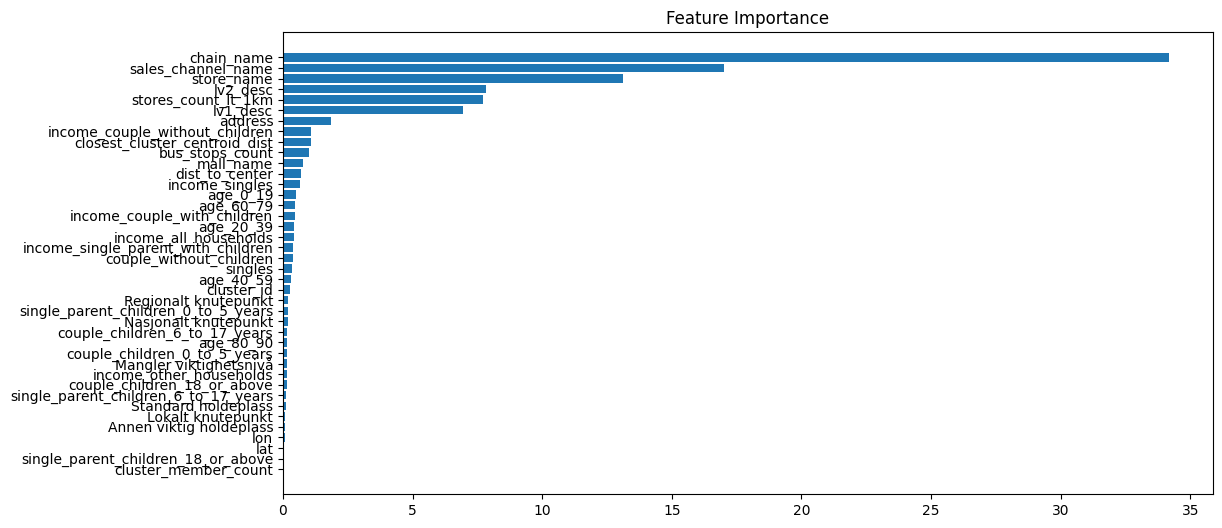

In [99]:
feature_importance = cbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_cb.columns)[sorted_idx])
plt.title('Feature Importance')

### Making predictions with LightGBM

In [100]:
non_tunable_lgb_params, tunable_lgb_params = get_hyper_parameters(get_lgb_params, n_trials=400)

dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
lgbm = lgb.train(
    params={**non_tunable_lgb_params, **tunable_lgb_params},
    train_set=dtrain_lgb,
    valid_sets=dvalid_lgb,
    verbose_eval=False
)
y_val_pred_cb = np.expm1(lgbm.predict(X_val_lgb))
score = rmsle(np.expm1(y_val), y_val_pred_cb)
print(score)

# lgbm_model.booster_.save_model(f'models/lgbm/{score:.5f}')

[I 2022-11-12 15:44:41,100] A new study created in memory with name: hyperparam-tuning
[I 2022-11-12 15:44:42,021] Trial 0 finished with value: 0.7513942081717853 and parameters: {'lambda_l1': 8.343666381566777e-08, 'lambda_l2': 2.443800561895946e-08, 'num_leaves': 157, 'feature_fraction': 0.819790483747953, 'min_child_samples': 69, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7513942081717853.
[I 2022-11-12 15:44:42,423] Trial 1 finished with value: 0.7594875113151517 and parameters: {'lambda_l1': 4.7523867292673283e-07, 'lambda_l2': 2.7992605640818844e-07, 'num_leaves': 97, 'feature_fraction': 0.6982667583506843, 'min_child_samples': 29, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7513942081717853.
[I 2022-11-12 15:44:42,802] Trial 2 finished with value: 0.7506193672497826 and parameters: {'lambda_l1': 1.1230452210411617, 'lambda_l2': 1.0526492457407037, 'num_leaves': 54, 'feature_fraction': 0.9514721390443188, 'min_child_samples': 9, 'boosting_type': 'dart'}. 

Number of finished trials: 400
Best trial (339):
Value: 0.7326664409876323
Params:
{'lambda_l1': 9.722260904445212e-05, 'lambda_l2': 6.421373712457918e-05, 'num_leaves': 16, 'feature_fraction': 0.41383078762992886, 'min_child_samples': 71, 'boosting_type': 'gbdt'}
0.7326664409876323


In [101]:
y_pred_cb = np.expm1(cbm.predict(X_val_cb))
print(rmsle(np.expm1(y_val), y_pred_cb))
y_pred_test_cb = np.expm1(cbm.predict(X_test_cb))

0.7240014137592843


In [102]:
dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
lgbm = lgb.train(
    params={**get_lgb_params()[1], **{'lambda_l1': 0.026873437304227192, 'lambda_l2': 9.270495297846024, 'num_leaves': 7, 'feature_fraction': 0.8633788253368204, 'min_child_samples': 81, 'boosting_type': 'gbdt'}},
    train_set=dtrain_lgb,
    valid_sets=dvalid_lgb,
    verbose_eval=False
)
y_val_pred_lgb = np.expm1(lgbm.predict(X_val_lgb))
score = rmsle(np.expm1(y_val), y_val_pred_lgb)
print(score)

y_pred_lgb = np.expm1(lgbm.predict(X_val_lgb))
print(rmsle(np.expm1(y_val), y_pred_cb))
y_pred_test_lgb = np.expm1(lgbm.predict(X_test_lgb))

0.7362712976984428
0.7240014137592843


In [103]:
automl_df = pd.read_csv('submissions/submission_automl.csv')
y_pred_test_automl = automl_df['predicted']

preds_test = np.array([y_pred_test_cb, y_pred_test_lgb])
preds_test_avg = np.mean(preds_test, axis=0)

submission = pd.read_csv('data/sample_submission.csv')
submission['predicted'] = preds_test_avg
submission.to_csv('submissions/cb_lgb_automl_stacked2.csv', index=False)

preds_test.shape

(2, 8577)